In [1]:
import pandas as pd

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [4]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [7]:
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import files
files.upload()

df = spark.read.csv('BostonHousing.csv',inferSchema=True, header=True)

from pyspark.ml.feature import VectorAssembler

df.columns


Saving BostonHousing.csv to BostonHousing (1).csv


['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv']

In [8]:
inputCols = [
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat'
]

only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feat_df=assembler.transform(df).select('features')

In [10]:
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)

X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

X_pca

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+---------

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



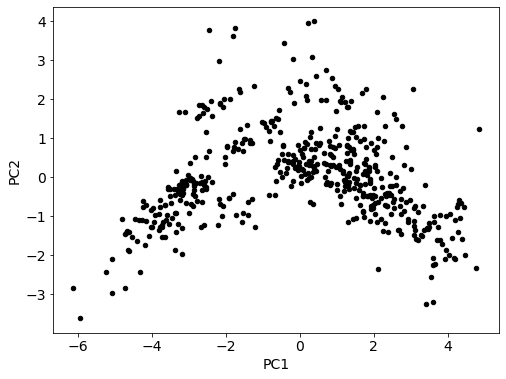

In [12]:
df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(x='PC1',y='PC2',c='Black')

output=assembler.transform(df)
f_data=output.select('features','medv')
f_data.show(5)

In [13]:
train_data,test_data= f_data.randomSplit([0.90,0.1])


In [14]:
regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)

In [15]:
coeff=regressor.coefficients
intr=regressor.intercept
print("The coefficient of the model is found to be:", coeff)
print("The intercept of the model is found to be:", intr)

print("The coefficient of the model is found to be: %a" %coeff)
print("The intercept of the model is found to be: %f" %intr)


The coefficient of the model is found to be: [-0.11021017721196674,0.046824878221273604,0.009362944054249938,2.7621315913073907,-17.477247006822218,3.5661325284834557,0.0025652425787599928,-1.4711636187231412,0.34097754405667347,-0.013089739909902405,-0.9494160084153739,0.00936486146050103,-0.5507736081625685]
The intercept of the model is found to be: 38.05086074121683
The coefficient of the model is found to be: DenseVector([-0.1102, 0.0468, 0.0094, 2.7621, -17.4772, 3.5661, 0.0026, -1.4712, 0.341, -0.0131, -0.9494, 0.0094, -0.5508])
The intercept of the model is found to be: 38.050861


In [16]:
pred = regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01096,55.0,2.2...|22.0|27.242911174625192|
|[0.02055,85.0,0.7...|24.7| 24.90662744798008|
|[0.02731,0.0,7.07...|21.6| 25.00781167902811|
|[0.03041,0.0,5.19...|18.5|19.485730976327922|
|[0.0315,95.0,1.47...|34.9|29.945975399536923|
+--------------------+----+------------------+
only showing top 5 rows



In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')

In [18]:
rmse=eval.evaluate(pred.predictions)
print("RMSE : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

RMSE : 4.163
MSE : 17.332
MAE : 2.998
r2 : 0.802
